# Radar observation : reflectivity composite of the new product

The aim of this notebook is to indicate how to read the reflectivity data of the new product. These data range from 01/02/2018 to 31/12/18 included. The radar emits a signal which is reflected by the precipitation. "Reflectivity" is the amount of transmitted power returned to the radar receiver after hitting precipitation, compared to a reference power density at a distance of 1 meter from the radar antenna.

For each pixel is indicated 3 data types:
<ul>
    <li>'data' : reflectivity values (in 1/10 dBZ) </li>
    <li>'prob' : rain probability (in %) </li>
    <li>'height' : selected measure height (in m) </li>
</ul>

The 'non detection data' value is -100 and the 'missing data' value is -200.

In this notebook, a formula is provided to convert the dBz into mm.h<sup>-1</sup>.

/!\ there are discontinuities between the old and the new reflectivity product. Here are the developments of the new version :
<ul>
    <li>new algorithm of data processing </li>
    <li>the minimum detection threshold is reducing from 8 to -9 dBZ </li>
    <li>the reflectivity values have a step of 0.5 dBZ </li>
    <li>addition of 2 products : the rain probability and the selected measure height</li>
</ul>

# Quickstart

In [1]:
from meteonet_toolbox.user_configuration import *
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import colors
from mpl_toolkits.basemap import Basemap, cm 

In [9]:
####Cell containing the modifiable fields######
zone = "SE"
year = 2018
month = 12
decade = 2
#min and max indexes when the dataset is loaded in memory -> it is useful if you have a small RAM 
# the maximum possible value is 3168 (1 data per 5 min at maximum for a 11 days maximal period -> 12*24*11 = 3168), with : 
# 12 : 12 data per hour (frequency = 5 min)
# 24 : 24 hours per day
# 11 : 11 days
ind_min = 10
ind_max = 25
fname = "../../data_samples/radar/reflectivity_new_%s_%s_%s.%s.npz" % (zone, str(year),"{:02d}".format(month),str(decade))
fname_coords = "../../data_samples/radar/radar_coords_%s.npz" % (zone)

#index of the chosen 5 min of the decade for the plot with basemap (/!\ after dataset loading) (cf last cell of the notebook) 
#/!\ 0 <= ind <= ind_max-ind_min 
ind = 10 #index of the chosen 5 min of the decade for the plot with basemap (cf last cell of the notebook)

#multiplication coefficient for the graphic representation of rainfall rate (in 1/coeff mm/h)
#/!\### the colorbar is adapted to the coefficient 10 (cf plot at the end)
coeff = 10         

In [10]:
#coordinates of study zone boundaries
lllat=DOMAINS[zone]['lry']    #lower left latitude
urlat=DOMAINS[zone]['uly']    #upper right latitude
lllon=DOMAINS[zone]['ulx']    #lower left longitude
urlon=DOMAINS[zone]['lrx']    #upper right longitude

In [11]:
def plot_data(fname, fname_coords,ind, ind_min,ind_max, title = "Examples of data plots"):
    ####data loading
    d = np.load(fname, allow_pickle=True)
    #reflectivity values
    data = d['data'][ind_min:ind_max,:,:]
    data[((data!=-200) & (data!=-100))] = data[((data!=-200) & (data!=-100))]/10      
    prob = d['prob'][ind_min:ind_max,:,:]
    height = d['height'][ind_min:ind_max,:,:]
    dates = d['dates'][ind_min:ind_max]        #associated dates values
    miss_dates = d['miss_dates'][ind_min:ind_max]        #missing dates values
    
    #title of plots
    title = str(dates[ind]) + " - "+  zone + " zone / -200 : 'missing data' value, -100 : 'non-detection data' value"

    #get the coordinates of the points
    coords = np.load(fname_coords, allow_pickle=True)
    lat = coords['lats']
    lon = coords['lons']
    
    #plots
    fig = plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(2, 2, figure = fig)
    
    fig.suptitle(title, fontsize=12)
    
    #reflectivity : colorbar definition
    if (np.nanmax(data) > 56):
        borne_max = np.nanmax(data)
    else:
        borne_max = 56 + 10
    cmap = colors.ListedColormap(['gray','silver','black','indigo','mediumblue','dodgerblue', 'skyblue','cyan',
                                  'olivedrab','lime','greenyellow','orange','red','magenta','pink'])
    bounds = [-200,-100,-9,-4,0,4,8,12,16,20,24,32,40,48,56,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax =  pl.subplot(gs[0, 0])    
    p1=ax.pcolormesh(lon, lat, data[ind,:,:],cmap=cmap, norm=norm)
    ax.set_ylabel('latitude (degrees_north)')
    ax.set_title("Reflectivity")
    pl.colorbar(p1,ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Reflectivity (in dBZ)')
    
    #height 
    
    height_plot = height
    height_plot[((height!=-200) & (height!=-100))] = height[((height!=-200) & (height!=-100))]/1000      
    
    if (np.nanmax(height_plot) > 12):
        borne_max = np.nanmax(height_plot)
    else:
        borne_max = 12 + 10
    cmap = colors.ListedColormap(['gray','silver','saddlebrown','firebrick','darkorange','bisque','yellow','greenyellow',
                                 'springgreen','cyan','skyblue','dodgerblue','mediumblue','darkblue','darkslateblue'])
    bounds = [-200,-100,0,1,2,3,4,5,6,7,8,9,10,11,12,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax =  pl.subplot(gs[0, 1])
    p2=ax.pcolormesh(lon, lat, height_plot[ind,:,:],cmap=cmap, norm=norm)
    ax.set_xlabel('longitude (degrees_east)')
    ax.set_title("Measure height")
    pl.colorbar(p2,ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Measure height (in km)')

    
    #rain probability
    
    
    cmap = colors.ListedColormap(['gray','silver','purple', 'deeppink','darkturquoise', 'dodgerblue','mediumblue','darkviolet','olivedrab'
                                      ,'lime','orange','red'])
    bounds = [-200,-100,0,10,20,30,40,50,60,70,80,90,100]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    ax =  pl.subplot(gs[1, 0])
    p3=ax.pcolormesh(lon, lat, prob[ind,:,:],cmap=cmap, norm=norm)
    ax.set_ylabel('latitude (degrees_north)')
    ax.set_xlabel('longitude (degrees_east)')
    ax.set_title("Rain probability")
    pl.colorbar(p3,ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Rain probability (in %)')    

#    cbar = fig.colorbar(pl,ax=ax.ravel().tolist(),cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Reflectivity (in dBZ) / '+ str(255) +' : missing values')
    return data,prob,height,height_plot,dates, miss_dates, lat, lon

<IPython.core.display.Javascript object>


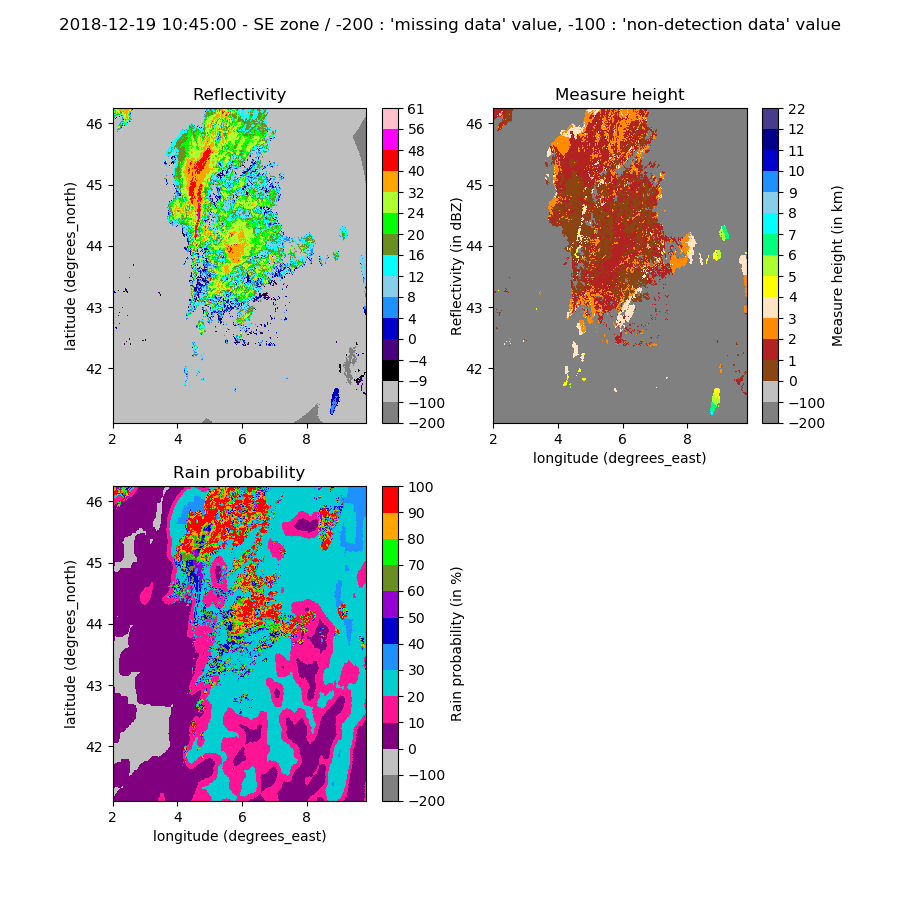

In [12]:
data,prob,height,height_plot,dates, miss_dates, lat, lon = plot_data(fname, fname_coords,ind, ind_min, ind_max)

# More details

The data are stored per period of 10 or 11 days per geographic zone (each month is separated in 3 files). The zones called 'NW' (for North-West of France) and 'SE' (for South-East of France).
The time step is 5 min (per day, start hour :00h and end hour : 23h55), the spatial resolution, 0.01° (the projection system is EPSG:4326).

In addition to reflectivity data, each file contains 2 time data categories : 
<ul>
    <li>'dates' : the associated dates to the reflectivity values</li>
    <li>'miss_dates' : the dates for which the data are missing</li>
</ul>

The min and max indexes defined in the second cell (allow to load just take a piece of data if you have a small RAM) apply to all datasets. 

**To get the coordinates (lat,lon) of the points :**
One npz file contains 2 arrays : one for the latitudes and one for the longitudes.

Dimensions of the 'data' array: 
<ul>
<li>time dimension (number of 5 min records) -> can be reduced and determined by min and max indexes when the dataset is loaded in memory (cf second cell)</li> 
<li>points number for longitude</li>
<li>points number for latitude</li>
</ul>  

In [13]:
data.shape

(15, 515, 784)

Dimensions of the 'dates' array:
<ul>
    <li>time dimension (number of 5 min records for which there are data) -> can be reduced and determined by min and max indexes when the dataset is loaded in memory (cf second cell)</li>
</ul>

In [14]:
dates.shape

(15,)

Dimensions of the 'miss_dates' array:
<ul>
    <li>time dimension (dates for which there are no data) -> can be reduced and determined by min and max indexes when the dataset is loaded in memory (cf second cell)</li>
</ul>

In [15]:
miss_dates.shape

(15,)

Overview of data of type int16

In [16]:
data

array([[[-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        ...,
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100]],

       [[-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        ...,
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100]],

       [[-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        ...,
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100],
        [-100, -100, -100, ..., -100, -100, -100]],

       ...,

       [[-100, -100, -10

Overview of 'dates' of type datetime.datetime

In [17]:
dates

array([datetime.datetime(2018, 12, 17, 6, 5),
       datetime.datetime(2018, 12, 17, 6, 40),
       datetime.datetime(2018, 12, 17, 6, 45),
       datetime.datetime(2018, 12, 17, 6, 50),
       datetime.datetime(2018, 12, 19, 10, 10),
       datetime.datetime(2018, 12, 19, 10, 15),
       datetime.datetime(2018, 12, 19, 10, 20),
       datetime.datetime(2018, 12, 19, 10, 25),
       datetime.datetime(2018, 12, 19, 10, 30),
       datetime.datetime(2018, 12, 19, 10, 35),
       datetime.datetime(2018, 12, 19, 10, 45),
       datetime.datetime(2018, 12, 20, 22, 45),
       datetime.datetime(2018, 12, 20, 22, 50),
       datetime.datetime(2018, 12, 20, 23, 5),
       datetime.datetime(2018, 12, 20, 23, 10)], dtype=object)

Overview of longitudes:

In [18]:
lon

array([[2.  , 2.01, 2.02, ..., 9.81, 9.82, 9.83],
       [2.  , 2.01, 2.02, ..., 9.81, 9.82, 9.83],
       [2.  , 2.01, 2.02, ..., 9.81, 9.82, 9.83],
       ...,
       [2.  , 2.01, 2.02, ..., 9.81, 9.82, 9.83],
       [2.  , 2.01, 2.02, ..., 9.81, 9.82, 9.83],
       [2.  , 2.01, 2.02, ..., 9.81, 9.82, 9.83]])

# Nice view using Basemap

Plot the different data for 1 given time step with a basemap

In [19]:
def plot_data_with_basemap(ind,data,height_plot,prob,dates,zone):
    
    title = str(dates[ind]) + " - "+  zone + " zone / -200 : 'missing data' value, -100 : 'non-detection data' value"
    
    #background map definition : coordinates of corners, resolution, projection type
    m = Basemap(epsg=n_epsg,resolution='i', # You can change the resolution of the contours here
                llcrnrlat=lllat,
                  urcrnrlat=urlat,
                  llcrnrlon=lllon,
                  urcrnrlon=urlon)
    
    fig = plt.figure(figsize=(10.5,12))
    gs = gridspec.GridSpec(2, 2, figure = fig)    
    fig.suptitle(title, fontsize=12)
    
    #reflectivity : colorbar definition
    if (np.nanmax(data) > 56):
        borne_max = np.nanmax(data)
    else:
        borne_max = 56 + 10
    cmap = colors.ListedColormap(['gray','silver','black','indigo','mediumblue','dodgerblue', 'skyblue','cyan',
                                  'olivedrab','lime','greenyellow','orange','red','magenta','pink'])
    bounds = [-200,-100,-9,-4,0,4,8,12,16,20,24,32,40,48,56,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax =  pl.subplot(gs[0, 0])   
    #plot the data and the background map (coastlines and borders)
    m.drawcoastlines()
    m.drawcountries()
    img=m.imshow(data[ind,:,:], interpolation='none', origin='upper',cmap=cmap, norm=norm)
    cb=pl.colorbar(img, ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'horizontal')
    cb.set_label('Reflectivity (in dBZ)')
    cb.ax.tick_params(labelsize=7)
    
    #measure height
    if (np.nanmax(height_plot) > 12):
        borne_max = np.nanmax(height_plot)
    else:
        borne_max = 12 + 10
    cmap = colors.ListedColormap(['gray','silver','saddlebrown','firebrick','darkorange','bisque','yellow','greenyellow',
                                 'springgreen','cyan','skyblue','dodgerblue','mediumblue','darkblue','darkslateblue'])
    bounds = [-200,-100,0,1,2,3,4,5,6,7,8,9,10,11,12,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax =  pl.subplot(gs[0, 1])
    m.drawcoastlines()
    m.drawcountries()
    img=m.imshow(height_plot[ind,:,:], interpolation='none', origin='upper',cmap=cmap, norm=norm)
    cb=pl.colorbar(img,ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'horizontal')
    cb.set_label('Measure height (in km)')
    cb.ax.tick_params(labelsize=7)
    
    #rain probability
    cmap = colors.ListedColormap(['gray','silver','purple', 'deeppink','darkturquoise', 'dodgerblue','mediumblue','darkviolet','olivedrab'
                                      ,'lime','orange','red'])
    bounds = [-200,-100,0,10,20,30,40,50,60,70,80,90,100]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    ax =  pl.subplot(gs[1, 0])
    m.drawcoastlines()
    m.drawcountries()    
    img=m.imshow(prob[ind,:,:], interpolation='none', origin='upper',cmap=cmap, norm=norm)
    cb=pl.colorbar(img,ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'horizontal')
    cb.set_label('Rain probability (in %)')  
    cb.ax.tick_params(labelsize=7)

    

C:\Users\larvorg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


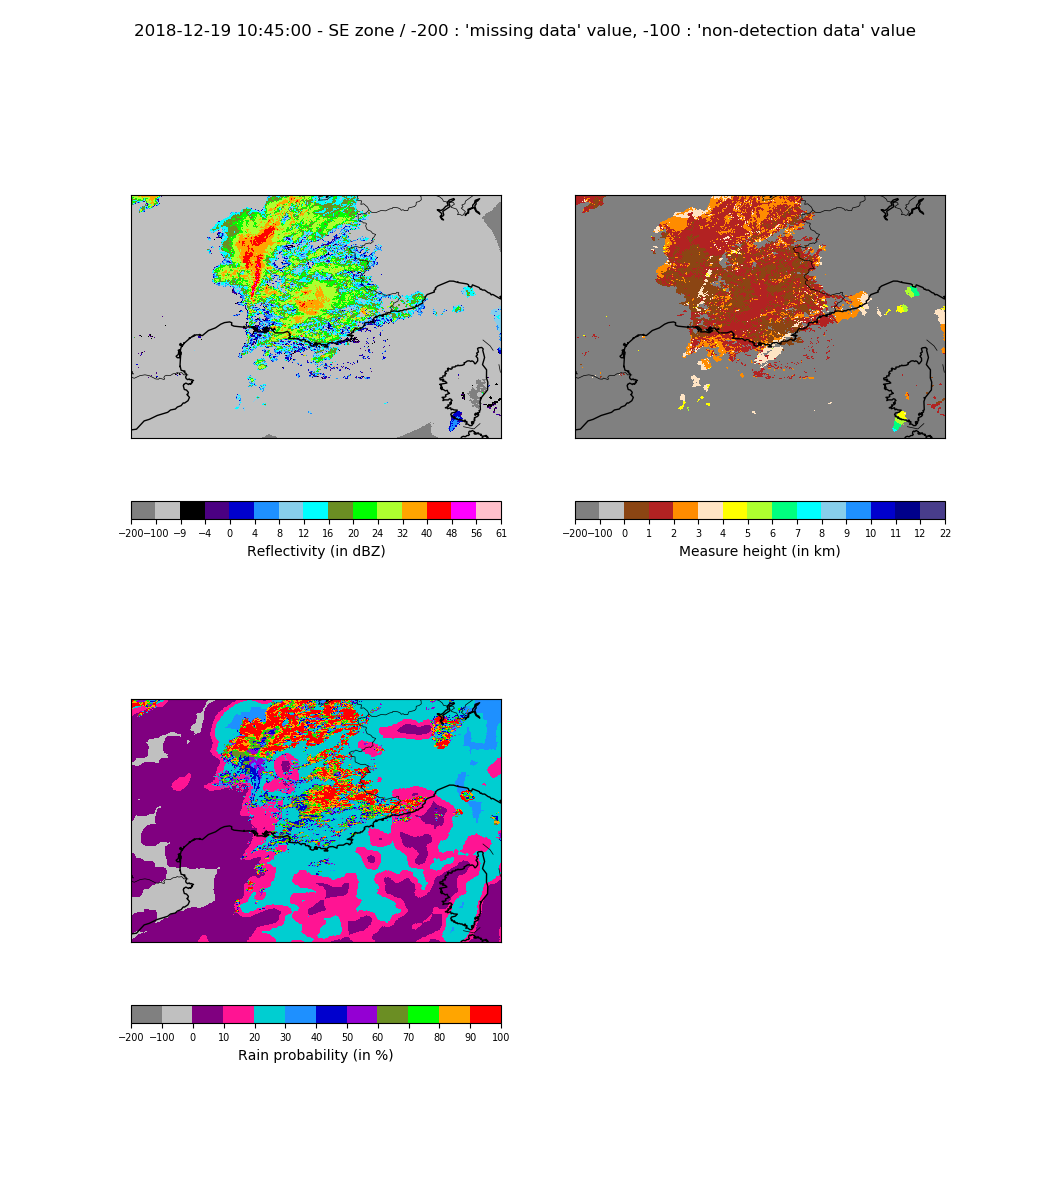

C:\Users\larvorg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [20]:
plot_data_with_basemap(ind,data,height_plot,prob,dates,zone)

# Convert dBZ into mm/h

In [23]:
def plot_mmh(data,coeff,ind, lat,lon, title = "4 examples of rainfall rate plots"):
        
    ##from dBZ to mm/h : Marshall-Palmer formula
    a = 200
    b = 1.6

    rr = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    rr[((data==-200) | (data==-100))]=np.nan
    rr[((data!=-200) & (data!=-100))] = (10**(data[((data!=-200) & (data!=-100))]/10)/a)**(1/b)
    
    rr_plot = coeff*rr
    
    #plots
    fig, ax = plt.subplots(2, 2,figsize=(9,9))
    fig.suptitle(title, fontsize=16)
    
    #colorbar definition
    #/!\### the scale is adapted to the coefficient 10
    if (np.nanmax(rr_plot) > 3646):
        borne_max = np.nanmax(rr_plot)
    else:
        borne_max = 3646 + 10
    cmap = colors.ListedColormap(['white', 'darkslateblue', 'mediumblue','dodgerblue', 'skyblue','olive','mediumseagreen'
                                      ,'cyan','lime','yellow','khaki','burlywood','orange','brown','red'])
    bounds = [0,2,4,6,12,21,36,65,115,205,365,648,1153,2050,3646,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    pl=ax[0,0].pcolormesh(lon, lat, rr_plot[ind,:,:],cmap=cmap, norm=norm)
    ax[0,0].set_ylabel('latitude (degrees_north)')
    ax[0,0].set_title(str(dates[ind]) + " - "+  zone + " zone")

    pl=ax[0,1].pcolormesh(lon, lat, rr_plot[ind+1,:,:],cmap=cmap, norm=norm)
    ax[0,1].set_title(str(dates[ind+1]) + " - "+  zone + " zone")

    pl=ax[1,0].pcolormesh(lon, lat, rr_plot[ind+2,:,:],cmap=cmap, norm=norm)
    ax[1,0].set_xlabel('longitude (degrees_east)')
    ax[1,0].set_ylabel('latitude (degrees_north)')
    ax[1,0].set_title(str(dates[ind+2]) + " - "+  zone + " zone")

    pl=ax[1,1].pcolormesh(lon, lat, rr_plot[ind+3,:,:],cmap=cmap, norm=norm)
    ax[1,1].set_xlabel('longitude (degrees_east)')
    ax[1,1].set_title(str(dates[ind+3]) + " - "+  zone + " zone")

    cbar = fig.colorbar(pl,ax=ax.ravel().tolist(),cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Rainfall rate (in 1/10 mm/h) / nan : missing values')
    plt.show()
    return rr

<IPython.core.display.Javascript object>


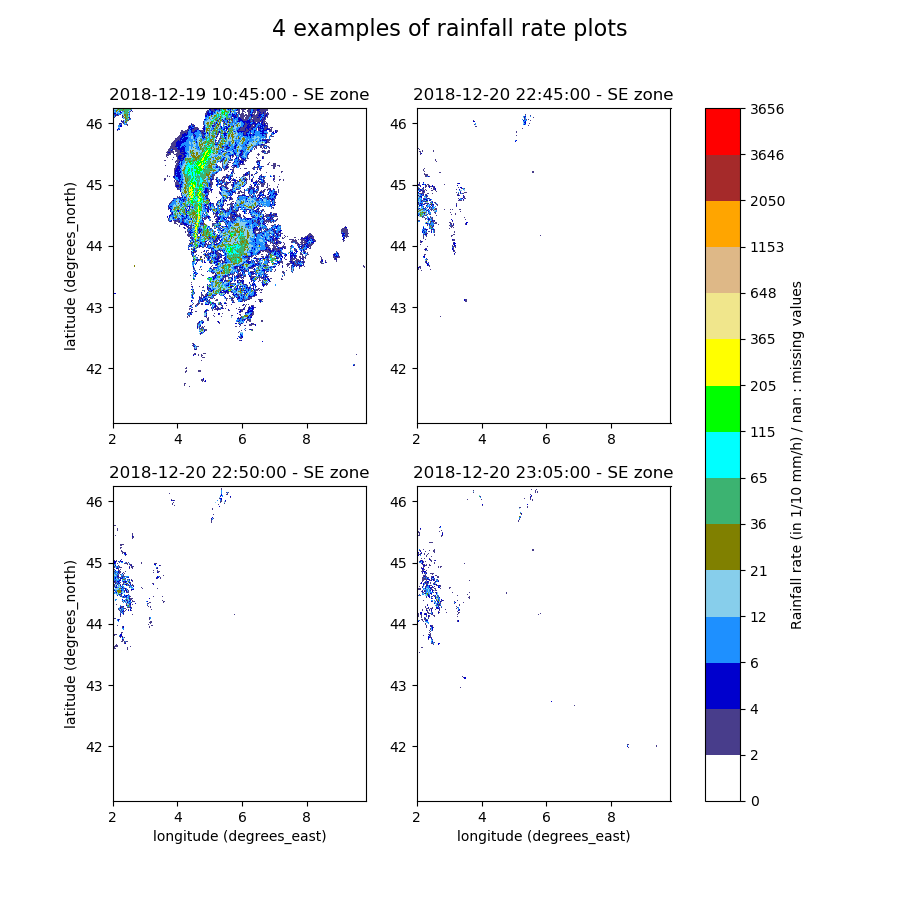

In [28]:
#/!\ these function works only if there are at least 3 dates later than this chosen for the plot with basemap (ind variable, cf second cell)
rr = plot_mmh(data,coeff,ind,lat,lon)

In [29]:
def plot_mmh_with_basemap(ind,coeff,rr,dates,zone):
    
    data_plot = coeff*rr
    fig,ax=plt.subplots(1,1,figsize=(10,12))

    #background map definition : coordinates of corners, resolution, projection type
    m = Basemap(epsg=n_epsg,resolution='i', # You can change the resolution of the contours here
                llcrnrlat=lllat,
                  urcrnrlat=urlat,
                  llcrnrlon=lllon,
                  urcrnrlon=urlon)

    #colorbar definition
    #/!\### the scale is adapted to the coefficient 10
    if (np.nanmax(data_plot) > 3646):
        borne_max = np.nanmax(data_plot)
    else:
        borne_max = 3646 + 10
    cmap = colors.ListedColormap(['white', 'darkslateblue', 'mediumblue','dodgerblue', 'skyblue','olive','mediumseagreen'
                                      ,'cyan','lime','yellow','khaki','burlywood','orange','brown','red'])
    bounds = [0,2,4,6,12,21,36,65,115,205,365,648,1153,2050,3646,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #plot the data and the background map (coastlines and borders)
    m.drawcoastlines()
    m.drawcountries()
    img=m.imshow(data_plot[ind,:,:], interpolation='none', origin='upper',cmap=cmap, norm=norm)
    plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'horizontal').set_label('Rainfall rate (in 1/10 mm/h) / nan : missing values')
    plt.title("Rainfall rate - "+ str(dates[ind]) + " - "+  zone + " zone")
    plt.show()

<IPython.core.display.Javascript object>


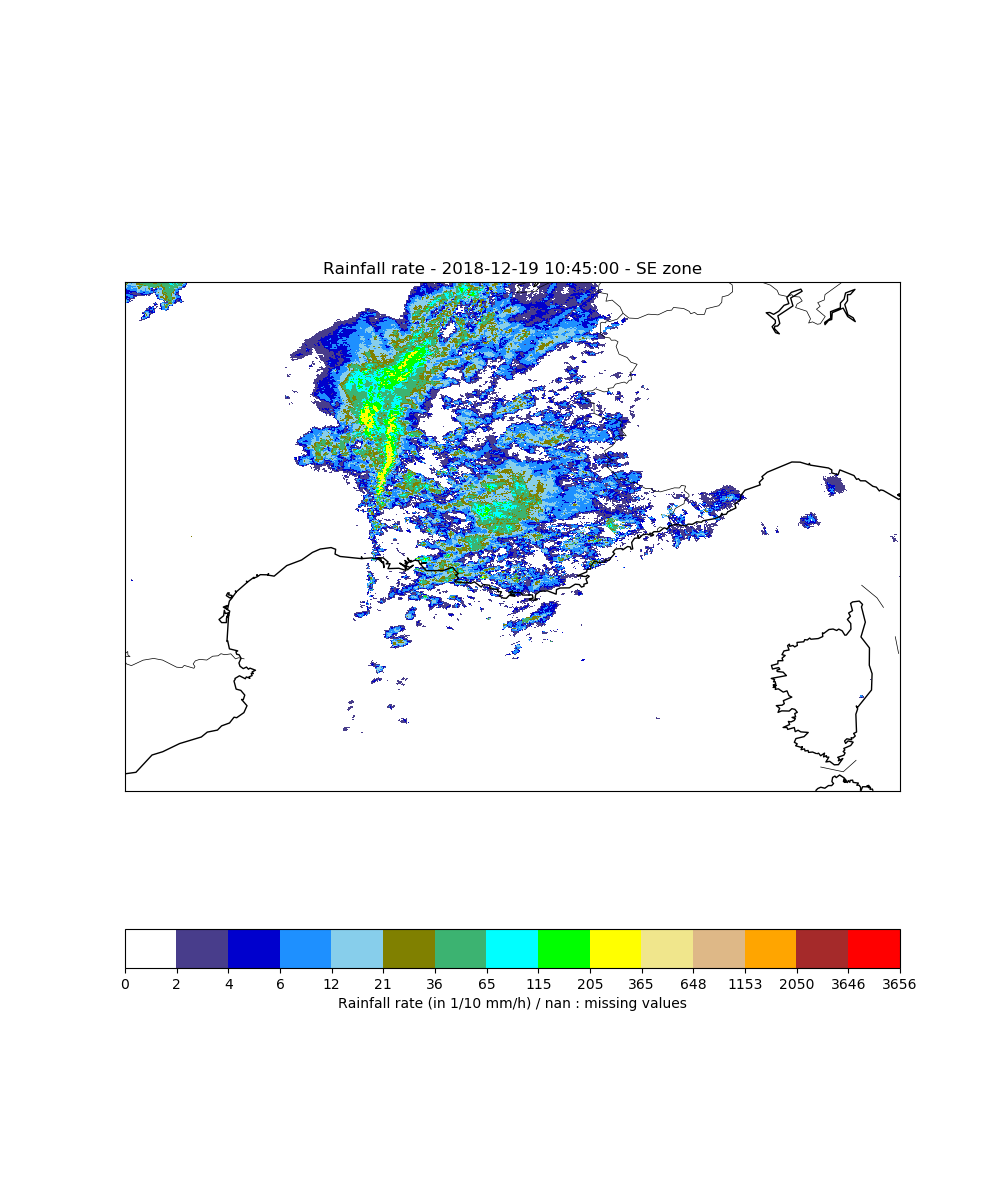

C:\Users\larvorg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\larvorg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [30]:
plot_mmh_with_basemap(ind,coeff,rr,dates,zone)

In [18]:
d.fid.close()